# Ray Train

In this notebook we are going to explore the following topics:

- Introduction to Ray Train
- Core concepts
- Getting started with Ray Train: scaling PyTorch training
- Lightning Torch example

Reference: https://docs.ray.io/en/latest/train/train.html

# Introduction to Ray Train

### What is Ray Train?

Ray Train is a scalable machine learning library designed for distributed training and fine-tuning of models built on top of Ray framework. It simplifies the process of scaling model training from a single machine to a cluster, allowing for efficient handling of large datasets and models.

### Why use Ray Train?

Existing distributed systems target different steps in ML. Ray provides one distributed framework to stitch them together, making MLops simpler.

<div style="text-align: center;">
    <img src="Images/distributed_systems.png" alt="Existing Distributed Systems vs Ray Distributed System" style="width:50%;">
    <p style="margin-top: 8px; text-align: center;"><em>Fig1: Existing Distributed Systems vs Ray Distributed System</em></p>
</div>


Ray Train offers a combination of **ease of use**, **scalability**, **performance**, and **integration capabilities** that make it a compelling choice for distributed Machine Learning training. It is particularly well-suited for users who are already leveraging the Ray ecosystem for other distributed computing tasks or who need a flexible and scalable solution for their machine learning workloads.

Ray Train provides support for many frameworks:
- **PyTorch ecosystem**
    - PyTorch
    - PyTorch Lightning
    - Hugging Face Transformers
    - Hugging Face Accelerate
    - DeepSpeed
<p>

- **More frameworks**
    - TensorFlow
    - Keras
    - Hugging Face Transformers
    - Horovod
    - XGBoost

## Core concepts

Four main concepts to understand Ray Train:
1. **Training Function**: a user-defined Python function that contains the logic for your model training.
    
2. **Workers**: processes responsible for running the training function across the cluster. The number of workers determines the parallelism of the training job and can be configured using the *ScalingConfig*. Each worker executes a portion of the training workload, either on a CPU or GPU.

3. **Scaling Configuration**: specifies the number of workers and required compute resources (e.g., GPUs, CPUs).

4. **Trainer**: a class that integrates the training function, workers, and scaling configuration to manage and execute distributed training tasks.

<div style="text-align: center;">
    <img src="Images/ray_train.png" alt="Ray Train overview" style="width:50%;">
    <p style="margin-top: 8px; text-align: center;"><em>Fig2: Ray Train overview</em></p>
</div>

The final code of a basic training with Ray Train will be something like this:
```
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer

# Training function
def train_func():
    # Your PyTorch training code here.
    ...

# Scaling configuration
scaling_config = ScalingConfig(num_workers=2, use_gpu=True)

# Trainer
trainer = TorchTrainer(train_func, scaling_config=scaling_config)

# Use the .fit() method to execute the training job
result = trainer.fit()
```

## Getting started with Ray Train: scaling PyTorch training

Now we are going to use the **FashionMNIST dataset**, which contains grayscale images of 10 different categories of clothing items (e.g., shirts, trousers, and shoes). The images have a resolution of 28x28 pixels. The dataset consists of:

- Training set: 60,000 images
- Test set: 10,000 images

This dataset is often used as a benchmark for image classification tasks in machine learning.

We will train a simple neural network model using PyTorch to **classify** these images. The model consists of two **fully connected layers** and uses the **ReLU activation function** to learn features from the input data. The model is optimized using the **Adam optimizer** and evaluates performance with **CrossEntropyLoss**. The focus of this example is to see how to scale the training of the model using Ray Train.

<div style="text-align: center;">
    <img src="Images/FashionMNIST_example_1.png" alt="Fig3: Existing Distributed Systems vs Ray Distributed System" style="width:50%;">
    <p><em>Fig3: Examples of images in the FashionMNIST dataset</em></p>
</div>

Label   Description

0         T-shirt/top

1         Trouser

2         Pullover

3         Dress

4         Coat

5         Sandal

6         Shirt

7         Sneaker

8         Bag

9         Ankle boot

- ### Environment configuration

Import the necessary libraries to start a remote Ray cluster.

In [1]:
# Environment configuration
from datetime import datetime
import ray

# Ray Train
import os
import tempfile
import time
import ray.train
import ray.train.torch

import matplotlib.pyplot as plt
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

/leonardo_work/tra26_castiel2/mviscia1/ray_rag_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-29 12:27:07,250	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-29 12:27:26,725	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-29 12:28:23,161	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
!which python

/leonardo_work/tra26_castiel2/mviscia1/ray_rag_venv/bin/python


Connecting to the Ray cluster started previously.

In [3]:
ray.init(log_to_driver = False, ignore_reinit_error = True)

2026-01-29 12:28:51,963	INFO worker.py:1520 -- Using address 10.1.0.82:27667 set in the environment variable RAY_ADDRESS
2026-01-29 12:28:51,963	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.1.0.82:27667...
2026-01-29 12:28:52,289	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://10.1.0.82:8265 


Python version:,3.11.7
Ray version:,2.44.0
Dashboard:,http://10.1.0.82:8265


Check cluster resources.

In [4]:
resources = ray.cluster_resources()

print(f"Cluster has {resources['CPU']} CPUs, {resources['GPU'] if 'GPU' in resources else 0} GPUs, execution memory {resources['memory'] * 1e-9} GBs, object storage memory {resources['object_store_memory'] * 1e-9} GBs")

Cluster has 16.0 CPUs, 2.0 GPUs, execution memory 359.45678684200004 GBs, object storage memory 154.05290864600002 GBs


In [5]:
print(resources)

{'node:10.1.0.82': 1.0, 'GPU': 2.0, 'accelerator_type:A100': 1.0, 'memory': 359456786842.0, 'CPU': 16.0, 'object_store_memory': 154052908646.0, 'node:__internal_head__': 1.0}


- ### Define all the ingredients to scale the training

### 1) Define a basic training loop function

The **Training function** defines the model training logic.

The following conventions are used:

- `train_func` is the function that contains the training code.
- `train_func` is passed into the *Trainer*’s `train_loop_per_worker` parameter.


In [6]:
# Training function executed by each worker in the distributed setup
def train_func():
    
    # Define the Model architecture (ResNet18) and adjust for single-channel input (FashionMNIST is grayscale)
    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    # 1) Prepare the model for distributed training
    model = ray.train.torch.prepare_model(model) # ensures that the model is wrapped in DistributedDataParallel (DDP) when multiple workers (GPUs) are detected
    # model.to("cuda")  # This is done by `prepare_model`
    # Define loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    # Data preparation: apply normalization and create DataLoader
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_FashionMNIST"
    train_data = FashionMNIST(root=data_dir, train=True, download=False, transform=transform)
    train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    
    # 2) Prepare the DataLoader for distributed training
    train_loader = ray.train.torch.prepare_data_loader(train_data_loader) # ensures correct data sharding and shuffling across workers.
    # Training loop for 10 epochs
    metrics_list = []
    for epoch in range(10):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        # Ensure epoch-based shuffling for DDP
        if ray.train.get_context().get_world_size() > 1:
            train_loader.sampler.set_epoch(epoch)

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Accumulate loss
            epoch_loss += loss.item()
            num_batches += 1
    
        # Compute average loss for the epoch
        avg_loss = epoch_loss / num_batches
    
        # Report metrics and save checkpoint
        metrics = {"loss": avg_loss, "epoch": epoch}
    
        checkpoint_dir = os.path.join("/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint" f"epoch_{epoch}")
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save(
            model.module.state_dict() if hasattr(model, "module") else model.state_dict(),
            os.path.join(checkpoint_dir, "model.pt")
        )
    
        ray.train.report(
            metrics,
            checkpoint=ray.train.Checkpoint.from_directory(checkpoint_dir),
        )


Your training function is running in a distributed setup using Ray Train and PyTorch Distributed Data Parallel (DDP). Inside each Ray worker, PyTorch's Distributed Data Parallel (DDP) helps distribute training across multiple GPUs. 
When you call:

`model = ray.train.torch.prepare_model(model)`

- Ray checks if multiple workers exist.
- If num_workers > 1, Ray wraps the model in torch.nn.parallel.DistributedDataParallel (DDP).

When you call:
`train_loader = ray.train.torch.prepare_data_loader(train_data_loader)`

- DDP splits the batch across GPUs and synchronizes gradients across workers.

Each worker:
- Processes a different batch of data.
- Synchronizes gradients before updating model weights.

### 2) Define scaling configuration

 The two basic parameters for worker parallelism and compute resources are:

- `num_workers`: the number of workers (Ray actors) to launch. Each worker will reserve 1 CPU by default. The number of CPUs reserved by each worker can be overridden with the `resources_per_worker` argument.

- `use_gpu`: whether each worker should use a GPU or CPU. If True, training will be done on GPUs (1 per worker). 

In [7]:
# 4) Configure scaling and resource requirements
scaling_config = ray.train.ScalingConfig(num_workers=2, use_gpu=True, resources_per_worker={"CPU":6, "GPU": 1}) # try to change the number of workers

### 3) Define the Trainer and launch the distributed training

The Trainer coordinates distributed training by combining the training function, worker processes, and scaling configuration. It launches workers based on the `scaling_config`, sets up the distributed environment, and runs the training function across all workers. Ray provides framework-specific Trainer classes, and calling the fit() method triggers the execution of the training job

In [8]:
# Start timing
start_time = time.time()

checkpoint_dir = "/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint" ### Change to '/leonardo_scratch/large/userexternal/<your HPC username>'
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure the directory exists

# 5) Launch distributed training job
trainer = ray.train.torch.TorchTrainer(
        train_func,
        scaling_config=scaling_config,
        run_config=ray.train.RunConfig(
        storage_path= checkpoint_dir # Change default storage
        )
        # 5a) If running in a multi-node cluster, this is where you
        # should configure the run's persistent storage that is accessible
        # across all worker nodes. On Leonardo the storage is already accessible across all worker nodes.
        # run_config=ray.train.RunConfig(storage_path="..."),
    )

results = trainer.fit() # trigger the execution of the training job

# End timing
end_time = time.time()
training_time = end_time - start_time

2026-01-29 12:28:55,408	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2026-01-29 12:28:55,415	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2026-01-29 12:28:55,416	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2026-01-29 12:28:55 (running for 00:00:00.34)
Using FIFO scheduling algorithm.
Logical resource usage: 0/16 CPUs, 0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2026-01-29_12-28-55/TorchTrainer_2026-01-29_12-28-55/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2026-01-29 12:29:00 (running for 00:00:05.36)
Using FIFO scheduling algorithm.
Logical resource usage: 13.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2026-01-29_12-28-55/TorchTrainer_2026-01-29_12-28-55/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2026-01-29 12:29:05 (running for 00:00:10.37)
Using FIFO scheduling algorithm.
Logical resource usage: 13.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2

2026-01-29 12:30:41,994	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-28-55' in 0.0090s.
2026-01-29 12:30:41,996	INFO tune.py:1041 -- Total run time: 106.59 seconds (106.57 seconds for the tuning loop).


== Status ==
Current time: 2026-01-29 12:30:41 (running for 00:01:46.58)
Using FIFO scheduling algorithm.
Logical resource usage: 13.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2026-01-29_12-28-55/TorchTrainer_2026-01-29_12-28-55/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [9]:
print(f"Training Time: {training_time} seconds")

Training Time: 109.49142646789551 seconds


1. Ray spawns workers (depnding on num_workers) running train_func().
2. Each worker loads a model and wraps it using prepare_model().
3. Each worker gets a subset of data via prepare_data_loader().
4. Each worker computes forward + backward passes independently.
5. Gradients are synchronized across workers via PyTorch DDP.
6. Model updates happen simultaneously in all workers.
7. At the end of each epoch, Ray aggregates metrics and checkpoints.

In [10]:
print(results)

Result(
  metrics={'loss': 0.11681061757213258, 'epoch': 9},
  path='/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-28-55/TorchTrainer_b2288_00000_0_2026-01-29_12-28-55',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-28-55/TorchTrainer_b2288_00000_0_2026-01-29_12-28-55/checkpoint_000009)
)


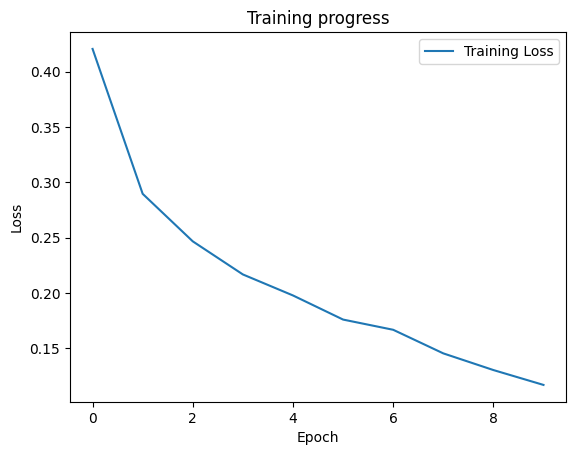

In [11]:
# Plot Loss training progress
plt.plot(results.metrics_dataframe['epoch'], results.metrics_dataframe['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training progress')
plt.legend()
plt.show()

- ### Test the model

In [12]:
# Define a Ray Actor for inference
@ray.remote(num_cpus=1)  # Use num_cpus=1 for CPU-based inference
class InferenceWorker:
    def __init__(self, checkpoint_path):
        # Load model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = resnet18(num_classes=10)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, image):
        print(self.device)
        image = image.to(self.device)
        with torch.no_grad():
            output = self.model(image)
            _, predicted = torch.max(output, 1)
        return predicted.item()

# Path to trained model checkpoint 
### Change with the path you obtained from the previous cell with print(results))
checkpoint_path = "/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-28_14-14-51/TorchTrainer_5486a_00000_0_2026-01-28_14-14-51/checkpoint_000009/model.pt"

# Prepare test dataset
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_FashionMNIST"
test_data = FashionMNIST(root=data_dir, train=False, download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [13]:
len(test_data)

10000

In [16]:
# Create multiple inference workers
num_workers = 12  # Adjust based on your resources
workers = [InferenceWorker.remote(checkpoint_path) for _ in range(num_workers)]

# Distribute inference across workers
futures = []
labels_list = []

for i, (images, labels) in enumerate(test_loader):
    worker = workers[i % num_workers]  # Distribute workload
    futures.append(worker.predict.remote(images))
    labels_list.append(labels.item())

In [17]:
# Gather predictions
predictions = ray.get(futures)

# Print first 10 predictions
for i, pred in enumerate(predictions[:10]):
    print(f"Sample {i}: Predicted Label: {pred}, Actual Label: {test_data.targets[i].item()}")

# Compute accuracy
correct = sum(p == l for p, l in zip(predictions, labels_list))
accuracy = correct / len(test_data)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Sample 0: Predicted Label: 9, Actual Label: 9
Sample 1: Predicted Label: 2, Actual Label: 2
Sample 2: Predicted Label: 1, Actual Label: 1
Sample 3: Predicted Label: 1, Actual Label: 1
Sample 4: Predicted Label: 6, Actual Label: 6
Sample 5: Predicted Label: 1, Actual Label: 1
Sample 6: Predicted Label: 0, Actual Label: 4
Sample 7: Predicted Label: 6, Actual Label: 6
Sample 8: Predicted Label: 5, Actual Label: 5
Sample 9: Predicted Label: 7, Actual Label: 7
Model Accuracy: 90.74%


# Exercise

Change the the scaling configuration and check how the training scales. You can try the following configurations:
- 1 worker with 6 CPUs and 4 GPUs
- 4 workers with 6 CPUs and 1 GPU each
- 2 workers with 6 CPUs and 1 GPU each

# Lightning Torch example

**PyTorch Lightning** is a high-level framework built on top of PyTorch that reduces the code base and automates many aspects of training, such as the training loop, validation, checkpointing, and distributed training. It allows you to focus on model design, while Lightning handles repetitive tasks. It supports best practices for modularity, scalability, and reproducibility, making it easier to experiment with complex models and scale training across multiple GPUs or nodes. It integrates seamlessly with other tools for logging, hyperparameter tuning, and optimization.

In [18]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
import torchvision

import ray.train.torch
import ray.train.lightning

In [19]:
# Define a PyTorch Lightning module for training a ResNet-18 model on the FashionMNIST dataset
class FashionMNISTModel(pl.LightningModule):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        # Define the model architecture (ResNet18)
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    # Define the training step that is called for each batch during training
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

In [20]:
# Training function executed by each worker in the distributed setup
def train_func():

    # Initialize the Lightning model
    model = FashionMNISTModel()
    
    # Data preparation: apply normalization and create DataLoader
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_FashionMNIST" 
    train_data = FashionMNIST(root=data_dir, train=True, download=False, transform=transform)
    train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)    

    # Use PyTorch Lightning Trainer for training
    trainer = pl.Trainer(max_epochs=10,
                        strategy=ray.train.lightning.RayDDPStrategy(),
                        plugins=[ray.train.lightning.RayLightningEnvironment()],
                        callbacks=[ray.train.lightning.RayTrainReportCallback()],
                        # [1a] Optionally, disable the default checkpointing behavior
                        # in favor of the `RayTrainReportCallback` above.
                        enable_checkpointing=False,
                    )

    trainer = ray.train.lightning.prepare_trainer(trainer)
    trainer.fit(model, train_dataloaders=train_data_loader)

In [21]:
# Start timing
start_time = time.time()

checkpoint_dir = "/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint" ### Change to '/leonardo_scratch/large/userexternal/<your HPC username>'

# Set up the scaling config for Ray Train
scaling_config = ray.train.ScalingConfig(
    num_workers=2,  # Number of workers (adjust as needed)
    use_gpu=True,  # Change to True if GPUs are available
)

# Launch the distributed training job with Ray
trainer = ray.train.torch.TorchTrainer(
    train_func, 
    scaling_config=scaling_config,
    run_config=ray.train.RunConfig(storage_path=checkpoint_dir)
)
    
results = trainer.fit()  # Trigger training

# End timing
end_time = time.time()
training_time = end_time - start_time

2026-01-29 12:36:16,185	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2026-01-29 12:36:16,188	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2026-01-29 12:36:16 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/16 CPUs, 0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2026-01-29_12-36-16/TorchTrainer_2026-01-29_12-36-16/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2026-01-29 12:36:21 (running for 00:00:05.15)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2026-01-29_12-36-16/TorchTrainer_2026-01-29_12-36-16/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2026-01-29 12:36:26 (running for 00:00:10.16)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/202

2026-01-29 12:37:57,583	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-36-16' in 0.0040s.
2026-01-29 12:37:57,584	INFO tune.py:1041 -- Total run time: 101.40 seconds (101.39 seconds for the tuning loop).


== Status ==
Current time: 2026-01-29 12:37:57 (running for 00:01:41.39)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /tmp/ray/session_2026-01-29_08-54-08_061617_2492228/artifacts/2026-01-29_12-36-16/TorchTrainer_2026-01-29_12-36-16/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [22]:
print(f"Training Time: {training_time} seconds")

Training Time: 101.4308226108551 seconds


In [23]:
print(results)

Result(
  metrics={'train_loss': 0.12187564373016357, 'train_loss_step': 0.0626777783036232, 'train_loss_epoch': 0.12187564373016357, 'epoch': 9, 'step': 2350},
  path='/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-36-16/TorchTrainer_b8e11_00000_0_2026-01-29_12-36-16',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-36-16/TorchTrainer_b8e11_00000_0_2026-01-29_12-36-16/checkpoint_000009)
)


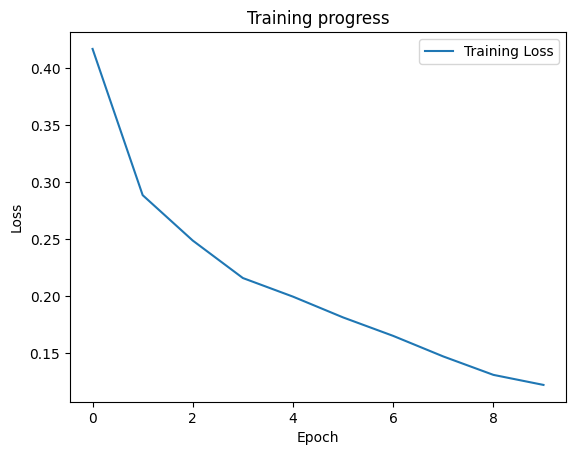

In [24]:
# Plot Loss training progress
plt.plot(results.metrics_dataframe['epoch'], results.metrics_dataframe['train_loss_epoch'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training progress')
plt.legend()
plt.show()

In [25]:
results.metrics_dataframe

,train_loss,train_loss_step,train_loss_epoch,epoch,step,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,0.416955,0.301048,0.416955,0,235,1769686614,checkpoint_000000,True,False,1,b8e11_00000,2026-01-29_12-36-54,21.141582,21.141582,2600688,lrdn0082.leonardo.local,10.1.0.82,21.141582,1
1,0.288522,0.192232,0.288522,1,470,1769686621,checkpoint_000001,True,False,2,b8e11_00000,2026-01-29_12-37-02,7.763780,28.905362,2600688,lrdn0082.leonardo.local,10.1.0.82,28.905362,2
2,0.248642,0.401121,0.248642,2,705,1769686628,checkpoint_000002,True,False,3,b8e11_00000,2026-01-29_12-37-08,6.670266,35.575629,2600688,lrdn0082.leonardo.local,10.1.0.82,35.575629,3
3,0.215748,0.138379,0.215748,3,940,1769686635,checkpoint_000003,True,False,4,b8e11_00000,2026-01-29_12-37-15,6.733796,42.309424,2600688,lrdn0082.leonardo.local,10.1.0.82,42.309424,4
4,0.199406,0.309622,0.199406,4,1175,1769686642,checkpoint_000004,True,False,5,b8e11_00000,2026-01-29_12-37-22,6.663811,48.973236,2600688,lrdn0082.leonardo.local,10.1.0.82,48.973236,5
5,0.181159,0.256965,0.181159,5,1410,1769686648,checkpoint_000005,True,False,6,b8e11_00000,2026-01-29_12-37-28,6.683479,55.656715,2600688,lrdn0082.leonardo.local,10.1.0.82,55.656715,6
6,0.164941,0.258945,0.164941,6,1645,1769686655,checkpoint_000006,True,False,7,b8e11_00000,2026-01-29_12-37-35,6.670319,62.327034,2600688,lrdn0082.leonardo.local,10.1.0.82,62.327034,7
7,0.146874,0.193392,0.146874,7,1880,1769686662,checkpoint_000007,True,False,8,b8e11_00000,2026-01-29_12-37-42,6.759127,69.086161,2600688,lrdn0082.leonardo.local,10.1.0.82,69.086161,8
8,0.130704,0.109167,0.130704,8,2115,1769686668,checkpoint_000008,True,False,9,b8e11_00000,2026-01-29_12-37-49,6.690054,75.776215,2600688,lrdn0082.leonardo.local,10.1.0.82,75.776215,9
9,0.121876,0.062678,0.121876,9,2350,1769686675,checkpoint_000009,True,False,10,b8e11_00000,2026-01-29_12-37-55,6.825975,82.602190,2600688,lrdn0082.leonardo.local,10.1.0.82,82.602190,10


# Exercise

- Use Ray Train to scale the training of the following model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_FashionMNIST" 
train_data = FashionMNIST(root=data_dir, train=True, download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Initialize the model, loss, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Solution

In [ ]:
import os
import tempfile
import torch
import ray
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig


# Definizione del modello
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Funzione di training
def train_func():
    # Preparare il modello per il training distribuito
    model = SimpleNN()
    model = ray.train.torch.prepare_model(model)

    # Definire la loss function e l'ottimizzatore
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Preparazione dei dati
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_FashionMNIST"  # Cambia con il percorso dei dati FashionMNIST
    train_data = datasets.FashionMNIST(
        root=data_dir, train=True, download=True, transform=transform
    )
    train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    train_loader = ray.train.torch.prepare_data_loader(train_data_loader)

    for epoch in range(10):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        # Ensure epoch-based shuffling for DDP
        if ray.train.get_context().get_world_size() > 1:
            train_loader.sampler.set_epoch(epoch)

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Accumulate loss
            epoch_loss += loss.item()
            num_batches += 1
    
        # Compute average loss for the epoch
        avg_loss = epoch_loss / num_batches
    
        # Report metrics and save checkpoint
        metrics = {"loss": avg_loss, "epoch": epoch}
    
        checkpoint_dir = os.path.join("/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint" f"epoch_{epoch}")
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save(
            model.module.state_dict() if hasattr(model, "module") else model.state_dict(),
            os.path.join(checkpoint_dir, "model.pt")
        )
    
        ray.train.report(
            metrics,
            checkpoint=ray.train.Checkpoint.from_directory(checkpoint_dir),
        )
    

In [ ]:
# Start timing
start_time = time.time()

# 4) Configure scaling and resource requirements
scaling_config = ray.train.ScalingConfig(num_workers=2,use_gpu=True) 

# 5) Launch distributed training job
trainer = ray.train.torch.TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    # 5a) If running in a multi-node cluster, this is where you
    # should configure the run's persistent storage that is accessible
    # across all worker nodes.
    # run_config=ray.train.RunConfig(storage_path="s3://..."),
)

results = trainer.fit() # trigger the execution of the training job

# End timing
end_time = time.time()
training_time = end_time - start_time

In [ ]:
print(f"Training Time: {training_time} seconds")

In [ ]:
print(results)

In [ ]:
# Plot Loss training progress
plt.plot(results.metrics_dataframe['epoch'], results.metrics_dataframe['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.show()

# Release resources

In [26]:
# Disconnect the worker, and terminate processes started by ray.init().
ray.shutdown()